In [162]:
!pip install isodate --quiet

In [296]:
import httpx
from bs4 import BeautifulSoup
import json
import isodate
import pandas as pd
import numpy as np

In [192]:
def _get_page(id_: str, title: bool = True, awards: bool = False):
    if title:
        url = f"https://www.imdb.com/title/{id_}"
    else:
        url = f"https://www.imdb.com/name/{id_}"

    if awards:
        url += "/awards"
        
    res = httpx.get(url,
            headers={
        		"content-type": "application/json",
    			"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:129.0) Gecko/20100101 Firefox/129.0"
        },
        follow_redirects=True,
        timeout=None
    )
    if res.status_code == 200 and res.text:
        print(res)
        return res.text

    return None

In [140]:
def get_page(id_: str, title: bool=True):
    return _get_page(id_=id_, title=title)

In [164]:
def process_page(page: str):
    soup = BeautifulSoup(page, "html.parser")
    script = soup.find("script", {"type":"application/ld+json"})
    if script:
        script_json = json.loads(script.text)
        return {
            "type": script_json.get("@type"),
            "url": script_json.get("url"),
            "name": script_json.get("name"),
            "image": script_json.get("image"),
            "description": script_json.get("description"),
            "description": script_json.get("description"),
            "rating": script_json.get("aggregateRating", {}).get("ratingValue"),
            "rating_count": script_json.get("aggregateRating", {}).get("ratingCount"),
            "content_rating": script_json.get("contentRating"),
            "genre": script_json.get("genre"),
            "keywords": script_json.get("keywords"),
            "date": script_json.get("datePublished"),
            "actors": script_json.get("actor"),
            "director": script_json.get("director"),
            "creator": script_json.get("creator"),
            "duration": isodate.parse_duration(script_json.get("duration")).total_seconds() / 60
        }

In [255]:
def process_additional_page_metadata(page: str):
    soup = BeautifulSoup(page, "html.parser")
    script = soup.find("script", {"id":"__NEXT_DATA__"})
    if script:
        script_json = json.loads(script.text)
        lifetime_gross = script_json.get("props", {}).get("pageProps", {}).get("mainColumnData", {}).get("lifetimeGross")
        budget = script_json.get("props", {}).get("pageProps", {}).get("mainColumnData", {}).get("productionBudget", {})
        popularity = script_json.get("props", {}).get("pageProps", {}).get("aboveTheFoldData").get("meterRanking", {})
        metascore = script_json.get("props", {}).get("pageProps", {}).get("aboveTheFoldData").get("metacritic", {})
        return {
            "popularity": popularity.get("currentRank", None) if popularity else None ,
            "metascore": metascore.get("metascore", {}).get("score", None) if metascore else None,
            "plot": script_json.get("props", {}).get("pageProps", {}).get("aboveTheFoldData").get("plot", {}).get("plotText", {}).get("plainText", None),
            "interests": [item.get("node", {}).get("primaryText", {}).get("text") for item in script_json.get("props", {}).get("pageProps", {}).get("aboveTheFoldData").get("interests", {}).get("edges", {})],
            "budget": {"amount": script_json.get("props", {}).get("pageProps", {}).get("mainColumnData", {}).get("productionBudget", {}).get("budget", {}).get("amount", 0) if budget else None,
                       "currency":script_json.get("props", {}).get("pageProps", {}).get("mainColumnData", {}).get("productionBudget", {}).get("budget", {}).get("currency", None) if budget else None},
            "gross": {"amount": lifetime_gross.get("total", {}).get("amount", 0) if lifetime_gross else None,
                       "currency": lifetime_gross.get("total", {}).get("currency", None) if lifetime_gross else None}
            
        }

In [141]:
def get_awards_page(id_: str, title: bool =True):
    return _get_page(id_=id_, title=title, awards=True)

In [142]:
def process_awards_page(page: str):
    soup = BeautifulSoup(page, "html.parser")
    awards = soup.find_all("section", class_="ipc-page-section")
    
    skip_sections = [
        "Contribute to this page",
        "More from this title",
        "Recently viewed"
    ]
    
    all_awards = []
    
    for award in awards:        
        h3 = award.find("h3")
        if h3:
            if h3.text not in skip_sections:
                award_name = h3.text
                
        ul = award.find("ul", class_="meta-data-award-list")
        
        if ul:                  
            lis = ul.find_all("li", class_="ipc-metadata-list-summary-item")
        
            for li in lis: 
                print(li.text)
                print("=" * 20)
                
                # data = {}
                # year_achievement = li.find("a", class_="ipc-metadata-list-summary-item__t")
                # if year_achievement:
                #     year, achievement = year_achievement.find(string=True, recursive=False).strip().split(" ")
                
                # if li.find(class_="awardCategoryName"):
                #     award_category_name = li.find(class_="awardCategoryName").text

                    
                # winners_nominees_ul = li.find(class_="ipc-metadata-list-summary-item__stl")
                # if winners_nominees_ul:
                #     winners_nominees = winners_nominees_ul.find_all("li")
                #     for winner_nominee in winners_nominees:
                #         award_for = winner_nominee.text.strip()
                #         data = {
                #             "year": int(year),
                #             "award_name": award_name,
                #             "achievement": achievement,
                #             "award_category_name": award_category_name,
                #             "award_for": award_for,
                #         }
                #         all_awards.append(data)
    return all_awards

In [151]:
def get_hidden_awards():
    url = "https://caching.graphql.imdb.com"
    params = {
        "operationName": "NameAwardsSubPagePagination",
        "variables": json.dumps({"after":"YW4wMTk4ODAx","const":"nm0000129","filter":{"events":["ev0000004"]},"first":50,"locale":"en-US","originalTitleText":False,"queryParams":"nmawd"}),
        "extensions": json.dumps({"persistedQuery":{"sha256Hash":"aa506f0fa08d88049180ee0ca73bf7af8be09708af1a2066023c29d1ee37bb5d","version":1}})
    }
    res = httpx.get(url,
              params=params,
            headers={
                    "content-type": "application/json",
                    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:129.0) Gecko/20100101 Firefox/129.0"
                    },
    )
    
    res.json()

In [275]:
def get_top_250_movies():
    url = "https://www.imdb.com/chart/top/"
    res = httpx.get(url, headers={
        		"content-type": "application/json",
    			"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:129.0) Gecko/20100101 Firefox/129.0"
        },
        follow_redirects=True,
        timeout=None)
    if res.status_code == 200:
        return res.text
    return None

def process_top_250_movies(page: str):
    soup = BeautifulSoup(page, "html.parser")
    metadata = soup.find("script", {"type":"application/ld+json"})
    if metadata:
        metadata_json = json.loads(metadata.text)
        return metadata_json.get("itemListElement")

In [273]:
top_250_page = get_top_250_movies()

In [278]:
processed_top_250 = process_top_250_movies(top_250_page)

In [287]:
top_250_imdb_ids = [item.get("item",{}).get("url").split("/")[-2] for item in processed_top_250]

In [288]:
imdb_top_250_results = []

for title in top_250_imdb_ids:
    print(f"Getting {title}...")
    page = get_page(id_=title, title=True)
    meta = process_page(page)
    additional_meta = process_additional_page_metadata(page)
    all_meta = meta | additional_meta
    imdb_top_250_results.append(all_meta)

with open("imdb_top_250.json", "w") as f:
    json.dump(imdb_top_250_results, f)


Getting tt0111161...
<Response [200 OK]>
Getting tt0068646...
<Response [200 OK]>
Getting tt0468569...
<Response [200 OK]>
Getting tt0071562...
<Response [200 OK]>
Getting tt0050083...
<Response [200 OK]>
Getting tt0108052...
<Response [200 OK]>
Getting tt0167260...
<Response [200 OK]>
Getting tt0110912...
<Response [200 OK]>
Getting tt0120737...
<Response [200 OK]>
Getting tt0060196...
<Response [200 OK]>
Getting tt0109830...
<Response [200 OK]>
Getting tt0167261...
<Response [200 OK]>
Getting tt0137523...
<Response [200 OK]>
Getting tt1375666...
<Response [200 OK]>
Getting tt0080684...
<Response [200 OK]>
Getting tt0133093...
<Response [200 OK]>
Getting tt0099685...
<Response [200 OK]>
Getting tt0073486...
<Response [200 OK]>
Getting tt0816692...
<Response [200 OK]>
Getting tt0114369...
<Response [200 OK]>
Getting tt0038650...
<Response [200 OK]>
Getting tt0047478...
<Response [200 OK]>
Getting tt0102926...
<Response [200 OK]>
Getting tt0120815...
<Response [200 OK]>
Getting tt031724

In [292]:
top250 = pd.read_json("imdb_top_250.json")

In [293]:
top250

,type,url,name,image,description,rating,rating_count,content_rating,genre,keywords,...,actors,director,creator,duration,popularity,metascore,plot,interests,budget,gross
0,Movie,https://www.imdb.com/title/tt0111161/,The Shawshank Redemption,https://m.media-amazon.com/images/M/MV5BNDE3OD...,A Maine banker convicted of the murder of his ...,9.3,2933446,R,[Drama],"prison,based on the works of stephen king,esca...",...,"[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Organization', 'url': 'https://www...",142,63.0,82.0,A Maine banker convicted of the murder of his ...,"[Epic, Period Drama, Prison Drama, Tragedy, Dr...","{'amount': 25000000, 'currency': 'USD'}","{'amount': 28767189, 'currency': 'USD'}"
1,Movie,https://www.imdb.com/title/tt0068646/,The Godfather,https://m.media-amazon.com/images/M/MV5BNTc0ZD...,"Don Vito Corleone, head of a mafia family, dec...",9.2,2044558,R,"[Crime, Drama]","mafia,patriarch,crime family,organized crime,g...",...,"[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Organization', 'url': 'https://www...",175,73.0,100.0,"Don Vito Corleone, head of a mafia family, dec...","[Epic, Gangster, Tragedy, Crime, Drama]","{'amount': 6000000, 'currency': 'USD'}","{'amount': 136381073, 'currency': 'USD'}"
2,Movie,https://www.imdb.com/title/tt0468569/,The Dark Knight,https://m.media-amazon.com/images/M/MV5BMTMxNT...,When the menace known as the Joker wreaks havo...,9.0,2913889,PG-13,"[Action, Crime, Drama]","psychopath,superhero,moral dilemma,clown,crimi...",...,"[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Organization', 'url': 'https://www...",152,90.0,84.0,When the menace known as the Joker wreaks havo...,"[Action Epic, Epic, Superhero, Action, Crime, ...","{'amount': 185000000, 'currency': 'USD'}","{'amount': 534987076, 'currency': 'USD'}"
3,Movie,https://www.imdb.com/title/tt0071562/,The Godfather Part II,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The early life and career of Vito Corleone in ...,9.0,1382521,R,"[Crime, Drama]","revenge,sicily,sicilian mafia,mother son relat...",...,"[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Organization', 'url': 'https://www...",202,239.0,90.0,The early life and career of Vito Corleone in ...,"[Epic, Gangster, Tragedy, Crime, Drama]","{'amount': 13000000, 'currency': 'USD'}","{'amount': 47834595, 'currency': 'USD'}"
4,Movie,https://www.imdb.com/title/tt0050083/,12 Angry Men,https://m.media-amazon.com/images/M/MV5BMWU4N2...,The jury in a New York City murder trial is fr...,9.0,880835,B,"[Crime, Drama]","jury,murder,dialogue driven,trial,jury room",...,"[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Organization', 'url': 'https://www...",96,329.0,97.0,The jury in a New York City murder trial is fr...,"[Legal Drama, Psychological Drama, Crime, Drama]","{'amount': 350000, 'currency': 'USD'}","{'amount': None, 'currency': None}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Movie,https://www.imdb.com/title/tt0061512/,Cool Hand Luke,https://m.media-amazon.com/images/M/MV5BNjcwNT...,A laid-back Southern man is sentenced to two y...,8.1,190495,Approved,"[Crime, Drama]","prison,fugitive,hard boiled egg,loss of mother...",...,"[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Person', 'url': 'https://www.imdb....","[{'@type': 'Organization', 'url': 'https://www...",127,3199.0,92.0,A laid-back Southern man is sentenced to two y...,"[Prison Drama, Tragedy, Crime, Drama]","{'amount': 3200000, 'currency': 'USD'}","{'amount': None, 'currency': None}"
246,Movie,https://www.imdb.com/title/tt0025316/,It Happened One Night,https://m.media-amazon.com/images/M/MV5BMDg5Mm...,A rogue reporter

In [294]:
top_250_out = top250

In [298]:
top_250_out.index = np.arange(1, len(top_250_out)+1)

In [306]:
# top_250_out["budget_amount"] = top_250_out["budget"].apply(lambda x: x.get("amount"))
top_250_out["budget_currency"] = top_250_out["budget"].apply(lambda x: x.get("currency"))

In [309]:
top_250_out["gross_amount"] = top_250_out["gross"].apply(lambda x: x.get("amount"))
top_250_out["gross_currency"] = top_250_out["gross"].apply(lambda x: x.get("currency"))

In [358]:
top250_out = top_250_out.drop(columns=["budget", "gross"])

<Axes: xlabel='budget_amount', ylabel='rating'>

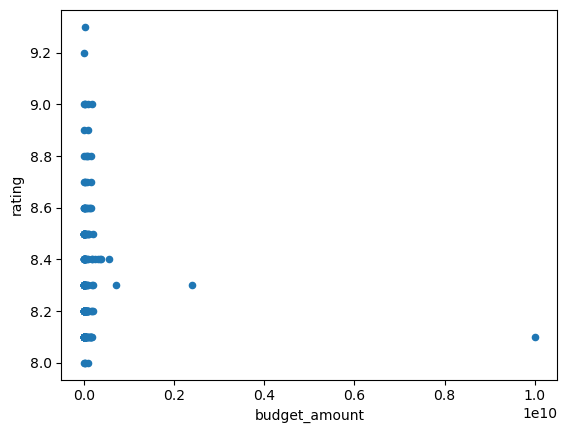

In [359]:
top_250_out[["budget_amount", "rating"]].dropna().plot(kind="scatter", x="budget_amount", y="rating")

In [361]:
top_250_out[top_250_out["budget_currency"] == "USD"].sort_values(by="budget_amount", ascending=False)

,type,url,name,image,description,rating,rating_count,content_rating,genre,keywords,...,popularity,metascore,plot,interests,budget,gross,budget_amount,budget_currency,gross_amount,gross_currency
78,Movie,https://www.imdb.com/title/tt4154796/,Avengers: Endgame,https://m.media-amazon.com/images/M/MV5BMTc5MD...,After the devastating events of Avengers: Infi...,8.4,1294237,C,"[Action, Adventure, Drama]","time travel,superhero,super villain,cosmic,mar...",...,151.0,78.0,After the devastating events of Avengers: Infi...,"[Space Sci-Fi, Superhero, Time Travel, Tragedy...","{'amount': 356000000, 'currency': 'USD'}","{'amount': 858373000, 'currency': 'USD'}",356000000.0,USD,858373000.0,USD
63,Movie,https://www.imdb.com/title/tt4154756/,Avengers: Infinity War,https://m.media-amazon.com/images/M/MV5BMjMxNj...,The Avengers and their allies must be willing ...,8.4,1228596,PG-13,"[Action, Adventure, Sci-Fi]","superhero,ensemble cast,marvel cinematic unive...",...,267.0,68.0,The Avengers and their allies must be willing ...,"[Space Sci-Fi, Superhero, Action, Adventure, S...","{'amount': 321000000, 'currency': 'USD'}","{'amount': 678815482, 'currency': 'USD'}",321000000.0,USD,678815482.0,USD
71,Movie,https://www.imdb.com/title/tt1345836/,The Dark Knight Rises,https://m.media-amazon.com/images/M/MV5BMTk4OD...,"Bane, an imposing terrorist, attacks Gotham Ci...",8.4,1851874,PG-13,"[Action, Drama, Thriller]","batman character,bruce wayne character,terrori...",...,193.0,78.0,"Bane, an imposing terrorist, attacks Gotham Ci...","[Action Epic, Epic, Superhero, Action, Drama, ...","{'amount': 250000000, 'currency': 'USD'}","{'amount': 448149584, 'currency': 'USD'}",250000000.0,USD,448149584.0,USD
92,Movie,https://www.imdb.com/title/tt0435761/,Toy Story 3,https://m.media-amazon.com/images/M/MV5BMTgxOT...,The toys are mistakenly delivered to a day-car...,8.3,903589,G,"[Animation, Adventure, Comedy]","toy,escape,recycling,sheriff,janitor",...,1354.0,92.0,The toys are mistakenly delivered to a day-car...,"[Computer Animation, Supernatural Fantasy, Urb...","{'amount': 200000000, 'currency': 'USD'}","{'amount': 415004880, 'currency': 'USD'}",200000000.0,USD,415004880.0,USD
176,Movie,https://www.imdb.com/title/tt10872600/,Spider-Man: No Way Home,https://m.media-amazon.com/images/M/MV5BZjI5Nm...,"With Spider-Man&apos;s identity now revealed, ...",8.2,901855,PG-13,"[Action, Adventure, Fantasy]","spider man character,superhero,marvel cinemati...",...,156.0,71.0,"With Spider-Man's identity now revealed, Peter...","[Superhero, Supernatural Fantasy, Urban Advent...","{'amount': 200000000, 'currency': 'USD'}","{'amount': 814866759, 'currency': 'USD'}",200000000.0,USD,814866759.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Movie,https://www.imdb.com/title/tt0012349/,The Kid,https://m.media-amazon.com/images/M/MV5BZjhhMT...,"The Tramp cares for an abandoned child, but ev...",8.2,136577,Passed,"[Comedy, Drama, Family]","the little tramp character,1910s,social worker...",...,NaN,NaN,"The Tramp cares for an abandoned child, but ev...","[Buddy Comedy, Slapstick, Comedy, Drama, Family]","{'amount': 250000, 'currency': 'USD'}","{'amount': None, 'currency': None}",250000.0,USD,NaN,None
159,Movie,https://www.imdb.com/title/tt0042876/,Rashômon,https://m.media-amazon.com/images/M/MV5BMjEzMz...,The rape of a bride and the murder of her samu...,8.2,183002,Not Rated,"[Crime, Drama, Mystery]","unreliable narration,contradictory accounts,mu...",...,4413.0,98.0,The rape of a bride and the murder of her samu...,"[Crime, Drama, Mystery]","{'amount': 250000, 'currency': 'USD'}","{'amount': 46808, 'currency': 'USD'}",250000.0,USD,46808.0,USD
182,Movie,https://www.imdb.com/title/tt0118849/,Bacheha-Ye aseman,https://m.media-amazon.com/images/M/MV5BZTYwZW...,After a boy loses his sister&apos;s pair of sh...,8.2,82105,PG,"[Drama, Family, Sport]","lost shoe,brother sister relationship,tehran i...",...,NaN,77.0,"After a boy loses his sister's

<Axes: xlabel='budget_amount', ylabel='rating'>

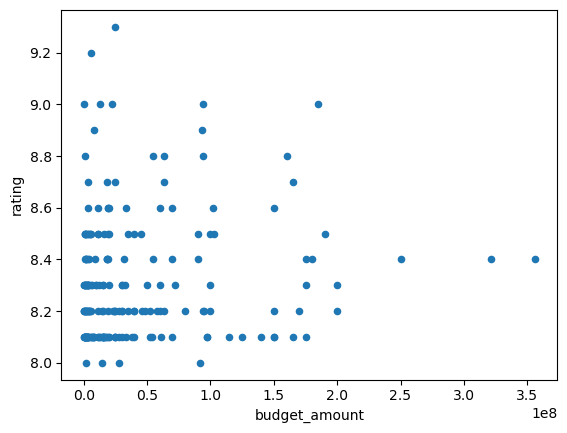

In [364]:
top_250_out[top_250_out["budget_currency"] == "USD"].plot(kind="scatter", x="budget_amount", y="rating")

<Axes: xlabel='budget_amount', ylabel='gross_amount'>

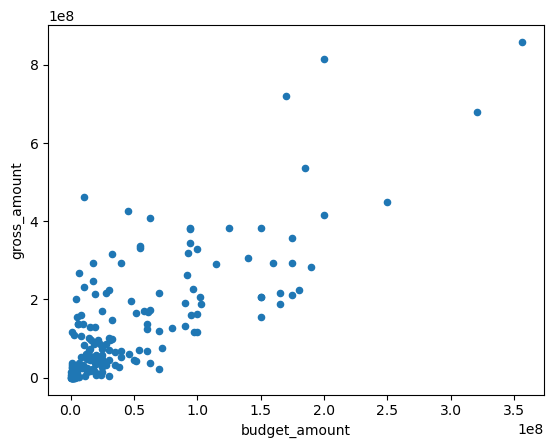

In [366]:
top_250_out[(top_250_out["gross_currency"] == "USD") & (top_250_out["budget_currency"] == "USD")].plot(kind="scatter", x="budget_amount", y="gross_amount")

In [369]:
top_250_out.drop(columns=["budget", "gross"], inplace=True)

In [372]:
top_250_out.to_csv("IMDB_Top250.csv")